In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net_v3 import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm.auto import tqdm
from pyprojroot.pyprojroot import here

tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

2022-08-23 02:16:11.651227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 02:16:12.038830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46713 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_video_gpt2_large.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]
sample_batch_size = 8

In [8]:
#dataset_length = 1578 
dataset_length = 10000
num_batch = dataset_length / batch_size

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[2,...]
    
    y = element[0:3,...]
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
drop_prob = 0.0 #0.2

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    #num_elements_to_keep = tf.random.uniform(shape=(1,), minval=5, maxval=tf.shape(element)[0], dtype=tf.int32)
    #remainder = tf.shape(element)[0] - num_elements_to_keep[0]
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

def video_to_ragged(element):
    element["y"] = tf.RaggedTensor.from_tensor(tf.expand_dims(element["y"], 0))
    return element
def squeeze_ragged(element):
    element["y"] = tf.squeeze(element["y"], axis=1)
    return element
def to_tensor(element):
    element["y"] = element["y"].to_tensor()
    return element

dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           #.map(video_to_ragged, num_parallel_calls=tf.data.AUTOTUNE)
           )

train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

train_sample_data = next(train_ds
                          .padded_batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).as_numpy_iterator())

train_ds = (train_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))

In [10]:
# Normalizing the images to [-1, 1]
def normalize(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    return image

In [26]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = element[:10]
    element = normalize(element)
    n_frames = tf.shape(element)[0]
    
    remaining_frames = tf.reverse(tf.range(n_frames), axis=[0])
    
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    remaining_frames = remaining_frames[idx_to_keep]
    
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0], "remaining_frames": remaining_frames}
def postprocess(batch):
    min_frames = tf.reduce_min(batch["n_frames"])
    first_frame_idx = tf.constant(0)
    frames_to_keep = min_frames - 2
    
    y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    remaining_frames = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    for i in tf.range(tf.shape(batch["y"])[0]):
        num_frames = batch["n_frames"][i]
        last_frame_idx = num_frames - 1
        all_indices = tf.range(1, num_frames - 1)
        indices = tf.sort(tf.random.shuffle(all_indices)[:frames_to_keep])
        indices = tf.concat([[first_frame_idx], indices, [last_frame_idx]], axis=0)
        y = y.write(i, tf.gather(batch["y"][i], indices))
        remaining_frames = remaining_frames.write(i, tf.gather(batch["remaining_frames"][i], indices))
        
    batch["remaining_frames"] = remaining_frames.stack()
    batch["y"] = y.stack()
    batch["n_frames"] = tf.repeat(min_frames, tf.shape(batch["y"])[0])
    
    return batch

In [27]:
dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(5000, reshuffle_each_iteration=True, seed=8)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )

In [28]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [29]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [30]:
train_sample_data = next(train_ds
                          .padded_batch(64)
                          #.map(postprocess)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(64)
                              #.map(postprocess)
                              .as_numpy_iterator())

In [31]:
train_ds = (train_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [17]:
take_train = [2, 8, 10, 16, 22, 33, 34, 49]
train_sample_data = postprocess({key: value[take_train] for key, value in train_sample_data.items()})
display_videos(train_sample_data["y"], n_rows=2, n_cols=4)

In [18]:
take_validation = [9, 14, 36, 42, 45, 47, 49, 63]
validation_sample_data = postprocess({key: value[take_validation] for key, value in validation_sample_data.items()})
display_videos(validation_sample_data["y"], n_rows=2, n_cols=4)

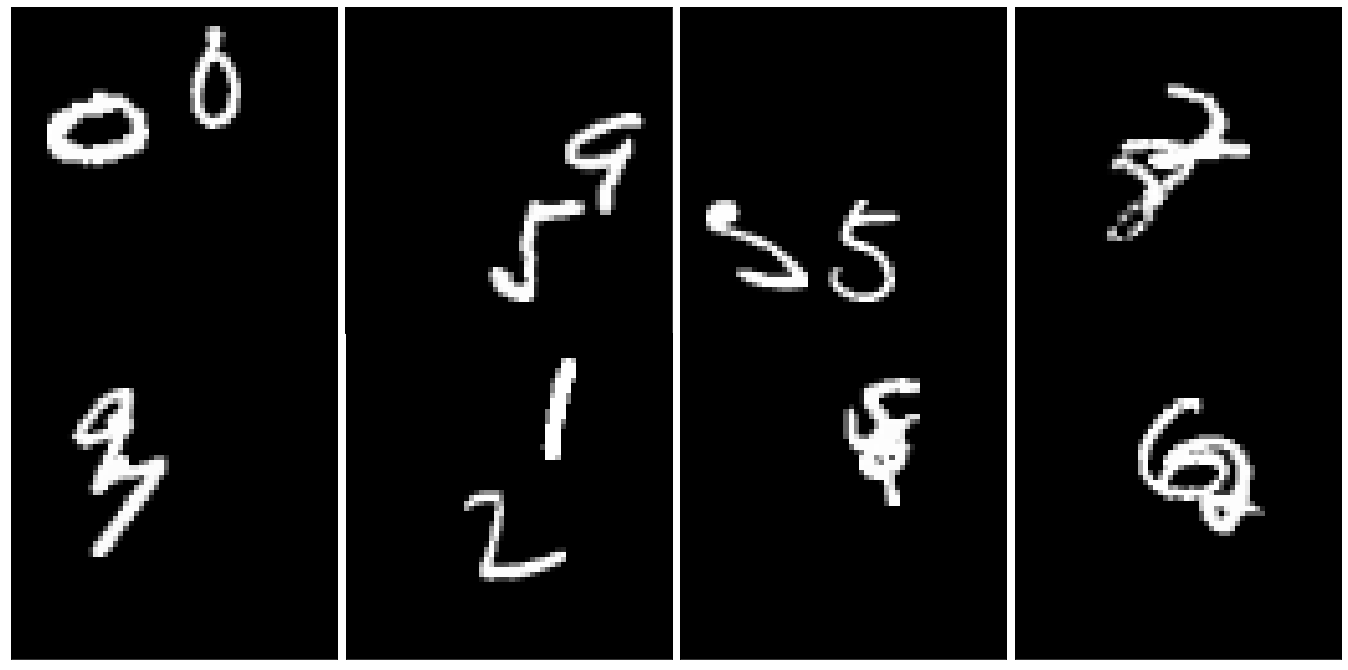

In [19]:
display_images(train_sample_data["first_frame"], 2, 4)
plt.show()

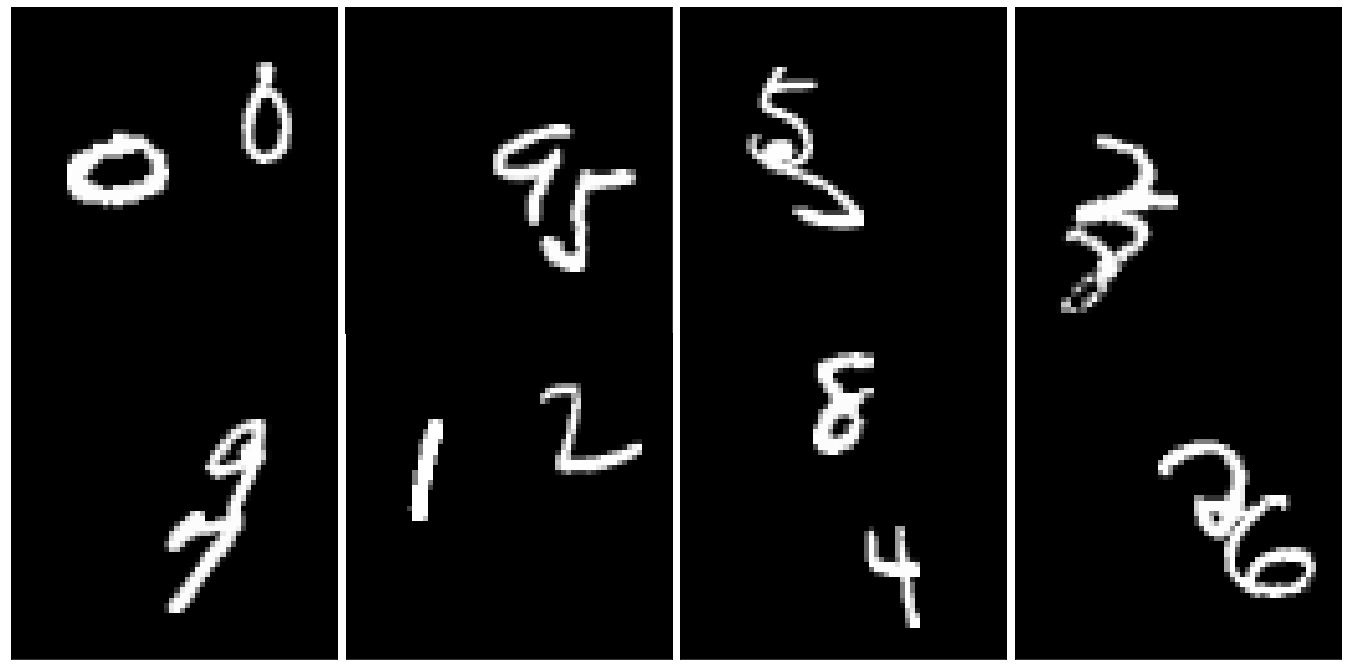

In [20]:
display_images(train_sample_data["last_frame"], 2, 4)
plt.show()

In [21]:
display_videos(train_sample_data["y"], n_rows=2, n_cols=4)

In [22]:
display_videos(validation_sample_data["y"], n_rows=2, n_cols=4)

train_ds = strategy.experimental_distribute_dataset(train_ds)
validation_ds = strategy.experimental_distribute_dataset(validation_ds)
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [23]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"], num_replicas=strategy.num_replicas_in_sync)
    #model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
    model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 512, 16, 16) = 131072 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
using method  own_embeddings


2022-08-23 02:16:23.446560: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-23 02:16:24.006308: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

Some layers of TFGPT2LMHeadModel were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['transformer/weight:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Restoring weights from ../../../checkpoints/moving_mnist_video_gpt2_large/checkpoint


for i in range(10):
    pbar = tqdm(train_ds)
    for data in pbar:
        output = strategy.run(model.train_step, args=(data,))
        pbar.set_postfix(loss=output["loss"].numpy())

In [43]:
with strategy.scope():
    generated_videos = model(train_sample_data, training=False)

In [44]:
display_videos(generated_videos, train_sample_data["y"], n_rows=2, n_cols=4)

In [45]:
from ganime.metrics.fvd import calculate_videos_metrics

In [46]:
dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(5000, reshuffle_each_iteration=True, seed=8)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

batch_size = 8

train_ds = (train_ds.padded_batch(batch_size, drop_remainder=True)
            #.map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(batch_size, drop_remainder=True)
            #.map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(batch_size, drop_remainder=True)
            #.map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [47]:
metrics_test = [calculate_videos_metrics(test_ds, model, validation_size // batch_size) for i in range(5)]
metrics_test

  0%|          | 0/125 [00:00<?, ?it/s]

2022-08-23 02:35:30.187301: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1fea0c80


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[{'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=63.800735>,
  'kvd': 7.462406758758789,
  'ssim': 0.69815814,
  'psnr': 22.020685},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=66.29593>,
  'kvd': 8.24835262462463,
  'ssim': 0.6967618,
  'psnr': 21.962124},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=63.89036>,
  'kvd': 7.711456656656679,
  'ssim': 0.6998465,
  'psnr': 22.028587},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=65.05945>,
  'kvd': 7.838443963963982,
  'ssim': 0.6982877,
  'psnr': 21.982565},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=65.334785>,
  'kvd': 7.844598982983001,
  'ssim': 0.6947047,
  'psnr': 21.958544}]

In [50]:
metrics_train = [calculate_videos_metrics(train_ds, model, train_size // batch_size) for i in range(5)]
metrics_train

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[{'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=60.890568>,
  'kvd': 7.91098676334542,
  'ssim': 0.6972449,
  'psnr': 21.98903},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=60.417374>,
  'kvd': 7.880170183272924,
  'ssim': 0.6973003,
  'psnr': 21.989813},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=61.548237>,
  'kvd': 8.10269982747846,
  'ssim': 0.69682926,
  'psnr': 21.983774},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=61.061775>,
  'kvd': 8.014753822227789,
  'ssim': 0.6970239,
  'psnr': 21.982235},
 {'fvd': <tf.Tensor: shape=(), dtype=float32, numpy=61.412174>,
  'kvd': 8.06372337342168,
  'ssim': 0.6967977,
  'psnr': 21.98136}]